In [1]:
%cd ..

/home/ubuntu/dev/reid/pepper


In [2]:
# builtin
from collections import Counter, defaultdict
from copy import deepcopy
import os.path as osp
import re
from shutil import copy2 as copy

# third-party
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

# mm
import mmcv
from mmcv import Config

In [3]:
class UnNormalize(object):
    def __init__(self, mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375]):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)  # WARN: this is inplace!!!
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

mean = [123.675, 116.28, 103.53]
std = [58.395, 57.12, 57.375]

unnorm = UnNormalize(mean=mean, std=std)

In [4]:
from pepper.datasets import build_dataset

In [5]:
cfg = Config.fromfile("tests/configs/_base_/datasets/mini_mars.py")
print(cfg.pretty_text)

img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
num_frames = 16
train_pipeline = [
    dict(type='VideoSampler', method='random_crop', seq_len=16),
    dict(type='LoadMultiImagesFromFile', to_float32=True),
    dict(
        type='SeqProbRandomResizedCrop',
        size=(256, 128),
        scale=(0.5, 1.0),
        crop_prob=0.5),
    dict(type='SeqRandomFlip', flip_prob=0.5, direction='horizontal'),
    dict(
        type='SeqRandomErasing',
        share_params=False,
        erase_prob=0.5,
        min_area_ratio=0.02,
        max_area_ratio=0.4),
    dict(
        type='SeqNormalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='VideoCollect', keys=['img', 'gt_label']),
    dict(type='FormatBundle')
]
test_pipeline = [
    dict(type='VideoSampler', method='evenly', seq_len=16),
    dict(type='LoadMultiImagesFromFile'),
    dict(type='SeqResize', size=(256, 128), i

In [6]:
def concat_tracklet(imgs, max_len=16):
    
    if isinstance(imgs, list):
        num_imgs = len(imgs)
        c, h, w = imgs[0].shape
    else:
        num_imgs, c, h, w = imgs.shape
    
    if num_imgs < max_len:
        max_len = num_imgs
        
    out = torch.zeros((c, h, w * max_len))
    for i in range(max_len):
        out[:, :, w * i : w * (i + 1)] = imgs[i]
        
    return out

# Train Pipeline!

In [7]:
train_dataset = build_dataset(cfg.data.train)

In [8]:
print(train_dataset.ann_file)
# print(train_dataset.data_infos)
print(len(train_dataset.data_infos))
print(len(train_dataset))

tests/data/mini_mars/gtPepper/train.json
32
32


In [9]:
sample = train_dataset[0]

sample_label = train_dataset.get_gt_labels()[0]

print(sample.keys())
print(type(sample['img'].data), type(sample['gt_label'].data), type(sample['img_metas']))
print(sample['img_metas'][0].data)
print(sample['img_metas'][-1].data)
print(sample['img'].data.shape)
print(sample_label)

dict_keys(['img', 'gt_label', 'img_metas'])
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'list'>
{'filename': 'tests/data/mini_mars/bbox_train/0003/0003C4T0003F006.jpg', 'ori_filename': 'bbox_train/0003/0003C4T0003F006.jpg', 'ori_shape': (256, 128, 3), 'img_shape': (256, 128, 3), 'pad_shape': (256, 128, 3), 'scale_factor': 1.0, 'flip': False, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}, 'pid': 1, 'camid': 3, 'frame_id': 5, 'is_video_data': True}
{'filename': 'tests/data/mini_mars/bbox_train/0003/0003C4T0003F021.jpg', 'ori_filename': 'bbox_train/0003/0003C4T0003F021.jpg', 'ori_shape': (256, 128, 3), 'img_shape': (256, 128, 3), 'pad_shape': (256, 128, 3), 'scale_factor': 1.0, 'flip': False, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float3

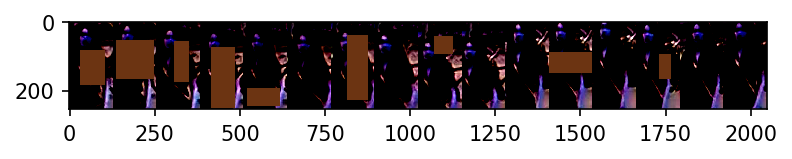

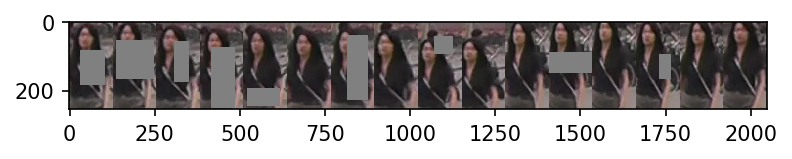

In [10]:
imgs = sample['img'].data

img = concat_tracklet(imgs)

unnorm_img = unnorm(deepcopy(img))
img = img.numpy().transpose((1, 2, 0))[:, :, [2, 1, 0]].clip(0, 1)
unnorm_img = unnorm_img.numpy().transpose((1, 2, 0)).astype(np.uint8)

plt.imshow(img, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

plt.imshow(unnorm_img, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

In [12]:
print(sample['gt_label'])
# print(len(sample['gt_label']))

DataContainer(tensor(1))


# Test Pipeline!

In [13]:
test_dataset = build_dataset(cfg.data.test)

/home/ubuntu/dev/reid/pepper/pepper/datasets/base_dataset.py:88: UserWarning: Using query/gallery as training data
  warnings.warn("Using query/gallery as training data")


In [14]:
sample = test_dataset[0]

print(sample.keys())

imgs = sample['img']

if isinstance(imgs, list):
    print(type(sample['img'][0]), type(sample['img_metas'][0].data))
    print(sample['img'][0].shape)
else:
    print(type(sample['img'].data), type(sample['img_metas']))
    print(sample['img_metas'][0].data)
    print(sample['img_metas'][-1].data)
    print(sample['img'].data.shape)

sample_label = test_dataset.get_gt_labels()[0]
print(sample_label)

dict_keys(['img_metas', 'img'])
dict_keys(['img', 'img_metas'])
<class 'torch.Tensor'> <class 'dict'>
torch.Size([3, 256, 128])
4


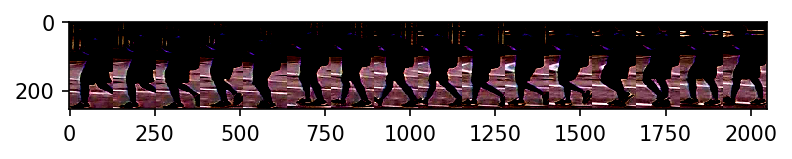

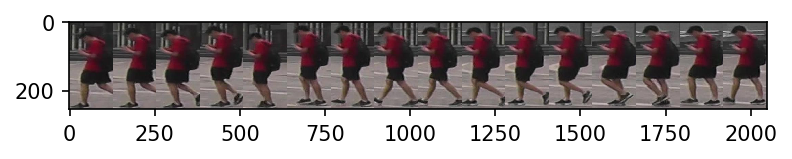

In [15]:
# This is for test pipeline!

img = concat_tracklet(imgs)

unnorm_img = unnorm(deepcopy(img))
img = img.numpy().transpose((1, 2, 0))[:, :, [2, 1, 0]].clip(0, 1)
unnorm_img = unnorm_img.numpy().transpose((1, 2, 0)).astype(np.uint8)

plt.imshow(img, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

plt.imshow(unnorm_img, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()
